In [1]:
import os
os.chdir('../')

In [352]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import matplotlib.image as mpimg
from tqdm.notebook import tqdm
from torchvision import transforms

# Paths

In [28]:
dataset_path = '/datasets/affwild2_latest'

videos_path = os.path.join(dataset_path, 'videos')
videos_batch1_path = os.path.join(videos_path, 'batch1')
videos_batch2_path = os.path.join(videos_path, 'batch2')

cropped_images_path = os.path.join(dataset_path, 'cropped_images')
cropped_images_batch1_path = os.path.join(cropped_images_path, 'batch1')
cropped_images_batch2_path = os.path.join(cropped_images_path, 'batch2')

cropped_aligned_images_path = os.path.join(dataset_path, 'cropped_aligned_images')

expr_set_train = os.path.join(dataset_path, 'annotations/EXPR_Set/Training_Set')
expr_set_valid = os.path.join(dataset_path, 'annotations/EXPR_Set/Validation_Set')

# Utility Functions

In [205]:
def read_videos(path, max_frames=5):
    
    vid = cv2.VideoCapture(path)
    frame_count = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = vid.get(cv2.CAP_PROP_FPS)
    frame_pipeline_out = []

    for i in range(frame_count):
        ret, frame = vid.read()

        if not ret or i == max_frames:
            break

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
        plt.show()

    vid.release()
    
    return frame_count, fps

def read_frame(path, idx=0):
    
    vid = cv2.VideoCapture(path)
    frame_count = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = vid.get(cv2.CAP_PROP_FPS)
    frame_pipeline_out = []

    for i in range(frame_count):
        ret, frame = vid.read()

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if not ret or i == idx:
            break
            
    vid.release()
    
    return frame, frame_count, fps

def list_intersection(lst1, lst2):
    
    extensions = ['.txt', '.mp4', '.avi']
    l1 = lst1.copy()
    l2 = lst2.copy()
    for i in range(len(lst1)):
        if lst1[i][-4:] in extensions:
            l1[i] = lst1[i][:-4]
        else:
            l1[i] = lst1[i]
            
    for i in range(len(lst2)):
        if lst2[i][-4:] in extensions:
            l2[i] = lst2[i][:-4]
        else:
            l2[i] = lst2[i]
            
    
    lst3 = [value for value in l1 if value in l2]
    return lst3

def read_labels(path):

    f = open(path, 'r')
    labels = []
    for line in f:
        labels.append(line[:-1])

    return labels

def get_matching_video(label, videos):
    
    for vid in videos:
        if label == vid[:-4]:
            return vid
    
    return ''

# Video  Exploration

* Batch 1 and Batch 2 have $\phi$ intersection

In [195]:
video_batch1 = sorted(os.listdir(videos_batch1_path))
video_batch2 = sorted(os.listdir(videos_batch2_path))

In [198]:
all_videos = video_batch1 + video_batch2

In [39]:
list_intersection(video_batch1, video_batch2)


[]

In [68]:
vl1 = len(video_batch1)
vl2 = len(video_batch2)
print(f'Batch 1 length: {vl1}')
print(f'Batch 2 length: {vl2}')
print(f'Total Length: {vl1 + vl2}')

Batch 1 length: 475
Batch 2 length: 73
Total Length: 548


Video Name: 1-30-1280x720.mp4
Resolution: (720, 1280, 3)
Frame Count: 10355
FPS: 30.0


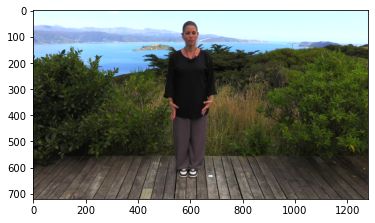

In [69]:
idx = 0
sample, sample_frame_count, sample_fps = read_frame(os.path.join(videos_batch1_path, video_batch1[idx]), 200)

print(f'Video Name:', video_batch1[idx])
print(f'Resolution: {sample.shape}')
print(f'Frame Count: {sample_frame_count}')
print(f'FPS: {sample_fps}')

plt.imshow(sample)

Video Name: video28.mp4
Resolution: (720, 1280, 3)
Frame Count: 8727
FPS: 30.0


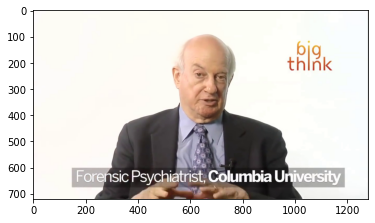

In [70]:
idx = 0
sample, sample_frame_count, sample_fps = read_frame(os.path.join(videos_batch2_path, video_batch2[idx]), 300)

print(f'Video Name:', video_batch2[idx])
print(f'Resolution: {sample.shape}')
print(f'Frame Count: {sample_frame_count}')
print(f'FPS: {sample_fps}')

plt.imshow(sample)

# Cropped Images Exploration

In [64]:
cropped_images_batch1 = sorted(os.listdir(cropped_images_batch1_path))
cropped_images_batch2 = sorted(os.listdir(cropped_images_batch2_path))

In [65]:
list_intersection(cropped_images_batch1, cropped_images_batch2)

[]

In [66]:
l1 = len(cropped_images_batch1)
l2 = len(cropped_images_batch2)
print(f'Batch 1 length: {l1}')
print(f'Batch 2 length: {l2}')
print(f'Total Length: {l1 + l2}')

Batch 1 length: 355
Batch 2 length: 209
Total Length: 564


In [56]:
# Intersection with Video batches
cropped_video_inter = list_intersection(cropped_images_batch1 + cropped_images_batch2, 
                                        video_batch1 + video_batch2)

len(cropped_video_inter)

535

Video Name: 100-29-1080x1920
Image Shape: (713, 498, 3)


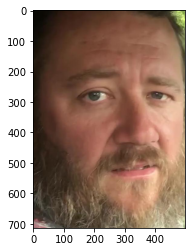

In [74]:
idx1 = 0
frame1 = 40
sample_cropped_folder1 = os.path.join(cropped_images_batch1_path, cropped_images_batch1[idx1])
sample_cropped_image1 = os.listdir(sample_cropped_folder1)[frame1]

cropped_img1 = mpimg.imread(os.path.join(sample_cropped_folder1, sample_cropped_image1))

print(f'Video Name: {cropped_images_batch1[idx1]}')
print(f'Image Shape: {cropped_img1.shape}')
plt.imshow(cropped_img1)

Frame Count: 10288
Video Name: 1-30-1280x720
Image Shape: (75, 54, 3)


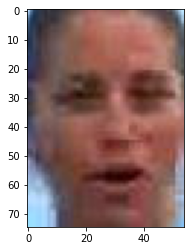

In [101]:
idx2 = 0
frame2 = 200
sample_cropped_folder2 = os.path.join(cropped_images_batch2_path, cropped_images_batch2[idx])
sample_cropped_image2 = sorted(os.listdir(sample_cropped_folder2))[frame2]

cropped_img2 = mpimg.imread(os.path.join(sample_cropped_folder2, sample_cropped_image2))

print(f'Frame Count: {len(os.listdir(sample_cropped_folder2))}')
print(f'Video Name: {cropped_images_batch2[idx]}')
print(f'Image Shape: {cropped_img2.shape}')
plt.imshow(cropped_img2)

# Cropped Aligned Images Exploration

* Faces are cropped and resized to (112, 112, 3)

In [79]:
cropped_aligned_images = sorted(os.listdir(cropped_aligned_images_path))

In [81]:
# Intersection with videos
len(list_intersection(cropped_aligned_images, video_batch1 + video_batch2))

535

In [82]:
# Intersection with cropped images
len(list_intersection(cropped_aligned_images, cropped_images_batch1 + cropped_images_batch2))

564

Frame Count: 10288
Video Name: 1-30-1280x720
Image Shape: (112, 112, 3)


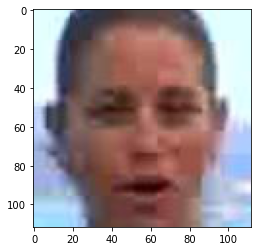

In [100]:
idx = 0
frame = 200
sample_cropped_folder = os.path.join(cropped_aligned_images_path, cropped_aligned_images[idx])
sample_cropped_image = sorted(os.listdir(sample_cropped_folder))[frame]

cropped_img = mpimg.imread(os.path.join(sample_cropped_folder, sample_cropped_image))

print(f'Frame Count: {len(os.listdir(sample_cropped_folder))}')
print(f'Video Name: {cropped_aligned_images[idx]}')
print(f'Image Shape: {cropped_img.shape}')
plt.imshow(cropped_img)

# Labels Exploration
0: Neutral

1: Anger

2: Disgust

3: Fear

4: Happiness

5: Sadness

6: Surprise

In [372]:
class_name = {
    0: 'Neutral',
    1: 'Anger',
    2: 'Disgust',
    3: 'Fear',
    4: 'Happiness',
    5: 'Sadness',
    6: 'surprise'
}

In [102]:
labels_train = os.listdir(expr_set_train)
labels_valid = os.listdir(expr_set_valid)

In [108]:
la1 = len(labels_train)
la2 = len(labels_valid)
print(f'Train Size: {la1}')
print(f'Valid Size: {la2}')
print(f'Total Length: {la1 + la2}')

Train Size: 253
Valid Size: 70
Total Length: 323


In [116]:
# intersections
print(f'Inter. of Train and Video batch 1: {len(list_intersection(labels_train, video_batch1))}')
print(f'Inter. of Train and Video batch 2: {len(list_intersection(labels_train, video_batch2))}')
print(f'Inter. of Valid and Video batch 1: {len(list_intersection(labels_valid, video_batch1))}')
print(f'Inter. of Valid and Video batch 2: {len(list_intersection(labels_valid, video_batch2))}')

print(f'Inter. of Train and aligned: {len(list_intersection(labels_train, cropped_aligned_images))}')
print(f'Inter. of Valid and aligned: {len(list_intersection(labels_valid, cropped_aligned_images))}')

Inter. of Train and Video batch 1: 231
Inter. of Train and Video batch 2: 15
Inter. of Valid and Video batch 1: 66
Inter. of Valid and Video batch 2: 2
Inter. of Train and aligned: 253
Inter. of Valid and aligned: 70


In [163]:
sample_label_train = os.path.join(expr_set_train, labels_train[0] + '.txt')
f = open(sample_label_train, 'r')
sample_labels = []
for line in f:
    sample_labels.append(line[:-1])

sample_labels[:10]

['Neutral,Anger,Disgust,Fear,Happiness,Sadness,Surprise',
 '0',
 '0',
 '0',
 '0',
 '4',
 '4',
 '4',
 '4',
 '4']

# Examining Alignment of Labels and Aligned Frames

In [253]:
fr = 13
label_ex = os.path.join(expr_set_train, labels_train[fr] + '.txt')

aligned_ex = list_intersection([labels_train[fr]], cropped_aligned_images)

video_ex = get_matching_video(labels_train[fr], all_videos)

vid_path = os.path.join(videos_batch1_path, video_ex)
if not os.path.exists(vid_path):
    vid_path = os.path.join(videos_batch2_path, video_ex)

_, frame_count, _ = read_frame(vid_path, 300)

labeled_frames = read_labels(label_ex)
aligned_frames = os.listdir(os.path.join(cropped_aligned_images_path, aligned_ex[0]))

print(f'Aligned Images Frame Count: {len(aligned_frames)}')
print(f'Labels Frame Count:         {len(labeled_frames)}')
print(f'Original Video Frame Count: {frame_count}')

Aligned Images Frame Count: 5202
Labels Frame Count:         5206
Original Video Frame Count: 5204


In [254]:
a = np.array(labeled_frames)

print(f'Number of Missing Labels in Video: {np.sum(a == str(-1))}')

Number of Missing Labels in Video: 0


In [260]:
total_count = 0
mismatch_count = 0
for i in tqdm(range(len(labels_train))):
    
    label_ex = os.path.join(expr_set_train, labels_train[i] + '.txt')

    aligned_ex = list_intersection([labels_train[i]], cropped_aligned_images)

    labeled_frames = read_labels(label_ex)
    aligned_frames = os.listdir(os.path.join(cropped_aligned_images_path, aligned_ex[0]))

    if len(aligned_frames) + 1 != len(labeled_frames):
        mismatch_count += 1
        
    total_count += 1
    

print(f'Percentage of Length Mismatching Train Videos {mismatch_count * 100 / total_count} %')


Percentage of Mismatching Videos 56.126482213438734 %


In [262]:
total_count = 0
mismatch_count = 0
for i in tqdm(range(len(labels_valid))):
    
    label_ex = os.path.join(expr_set_valid, labels_valid[i] + '.txt')

    aligned_ex = list_intersection([labels_valid[i]], cropped_aligned_images)

    labeled_frames = read_labels(label_ex)
    aligned_frames = os.listdir(os.path.join(cropped_aligned_images_path, aligned_ex[0]))

    if len(aligned_frames) + 1 != len(labeled_frames):
        mismatch_count += 1
        
    total_count += 1
    

print(f'Percentage of Length Mismatching Train Videos {mismatch_count * 100 / total_count} %')


Percentage of Length Mismatching Train Videos 62.857142857142854 %


# Torch Dataset

In [394]:
import os
os.chdir('/scratch/users/nnayal17/moody_much/MoodyMuch/ml')

import cv2
import numpy as np
import random
import torch
from torch.utils.data import Dataset
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from models.blazeface import BlazeFace

class AffWild2ExprDataset(Dataset):
    
    dataset_path = '/datasets/affwild2_latest'

    videos_path = os.path.join(dataset_path, 'videos')
    videos_batch1_path = os.path.join(videos_path, 'batch1')
    videos_batch2_path = os.path.join(videos_path, 'batch2')

    cropped_images_path = os.path.join(dataset_path, 'cropped_images')
    cropped_images_batch1_path = os.path.join(cropped_images_path, 'batch1')
    cropped_images_batch2_path = os.path.join(cropped_images_path, 'batch2')

    cropped_aligned_images_path = os.path.join(dataset_path, 'cropped_aligned_images')

    expr_set_train = os.path.join(dataset_path, 'annotations/EXPR_Set/Training_Set')
    expr_set_valid = os.path.join(dataset_path, 'annotations/EXPR_Set/Validation_Set')
    
    class_num_to_name = {
        0: 'Neutral',
        1: 'Anger',
        2: 'Disgust',
        3: 'Fear',
        4: 'Happiness',
        5: 'Sadness',
        6: 'Surprise'
    }
    
    class_name_to_num = {
        'Neutral':0,
        'Anger':1,
        'Disgust':2,
        'Fear':3,
        'Happiness':4,
        'Sadness':5,
        'Surprise':6
    }
    
    binary_class = {
        1: 'Positive',
        0: 'Negative'
    }
    
    
    def __init__(
        self, 
        train: bool = True, 
        skip: int = 0, 
        remove_mismatch: bool = False, 
        transform=None, 
        compress=False,
        binary=False
    ):
        
        self.skip = skip
        self.train = train
        self.compress = compress
        self.transform = transform
        self.binary = binary
        self.label_names = None
        self.labels_root = None
        self.random_seed(8)
        
        if train:
            self.label_names = os.listdir(self.expr_set_train)
            self.labels_root = self.expr_set_train
        else:
            self.label_names = os.listdir(self.expr_set_valid)
            self.labels_root = self.expr_set_valid
        
        cropped_aligned_images = os.listdir(self.cropped_aligned_images_path)
        self.video_names = self.list_intersection(self.label_names, cropped_aligned_images)
        
        self.video_names = sorted(self.video_names)
        self.label_names = sorted(self.label_names)
        
        self.videos = []
        self.labels = []
        
        positive_frames, negative_frames = [], []
        positive_labels, negative_labels = [], []
        
        for k, vid in enumerate(self.video_names):
            
            video_frames_path = os.path.join(self.cropped_aligned_images_path, vid)
            video_frames = os.listdir(video_frames_path)
            label_frames = self.read_labels(os.path.join(self.labels_root, self.label_names[k]))
            
            if remove_mismatch and len(video_frames) != len(label_frames):
                continue
            elif len(video_frames) != len(label_frames):
                min_length = min(len(video_frames), len(label_frames))
                video_frames = video_frames[:min_length]
                label_frames = label_frames[:min_length]
                
            video_frames = np.array(sorted(video_frames))
            label_frames = np.array(label_frames)
            
            remove_mask = label_frames != -1
            
            video_frames = video_frames[remove_mask]
            label_frames = label_frames[remove_mask]
            
            if compress:
                
                for i, frame in enumerate(video_frames):

                    if i % (skip + 1) != 0:
                        continue
                    
                    if binary:
                        
                        class_name = self.class_num_to_name[label_frames[i]]
                        if class_name in ['Neutral', 'Surprise']:
                            continue;
                        
                        if class_name == 'Happiness':
                            positive_frames.append(os.path.join(video_frames_path, frame))
                            positive_labels.append(1)
                        else:
                            negative_frames.append(os.path.join(video_frames_path, frame))
                            negative_labels.append(0)
                        
                    else:
                        self.videos.append(os.path.join(video_frames_path, frame))
                        self.labels.append(label_frames[i])

            else:
                video = []
                label = []
                for i, frame in enumerate(video_frames):

                    if i % (skip + 1) != 0:
                        continue

                    video.append(os.path.join(video_frames_path, frame))
                    label.append(label_frames[i])

                self.videos.append(video)
                self.labels.append(label)
        
        if binary:
            pos_len = len(positive_frames)
            neg_len = len(negative_frames)
            min_len = min(pos_len, neg_len)
            
            self.videos = np.asarray(positive_frames[:min_len] + negative_frames[:min_len])
            self.labels = np.asarray(positive_labels[:min_len] + negative_labels[:min_len])
            
            idx = np.arange(2 * min_len)
            np.random.shuffle(idx)
            
            self.videos = self.videos[idx]
            self.labels = self.labels[idx]
            
        self.length = len(self.videos)
    
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        
        
        if self.compress:
            img = mpimg.imread(self.videos[index])
            if self.transform:
                img = self.transform(img)
            
            return img, self.labels[index]
        
        frames = []
        for i in range(len(self.videos[index])):
            img = mpimg.imread(self.videos[index][i])
            if self.transform:
                img = self.transform(img)
            frames.append(img)
        
        frames = np.asarray(frames)
        frames = torch.from_numpy(frames.astype(np.float32))
        if len(frames.size()) != 4:
            print(f'WARNING: Frames of Size {frames.shape} was found')
        frames = frames.permute(0, 3, 1, 2)
        
        labels = np.asarray(self.labels[index])
        labels = torch.from_numpy(labels)
        
        return frames, label
     
    def list_intersection(self, lst1, lst2):
    
        extensions = ['.txt', '.mp4', '.avi']

        for i in range(len(lst1)):
            if lst1[i][-4:] in extensions:
                lst1[i] = lst1[i][:-4]

        for i in range(len(lst2)):
            if lst2[i][-4:] in extensions:
                lst2[i] = lst2[i][:-4]


        lst3 = [value for value in lst1 if value in lst2]
        return lst3   
    
    def read_labels(self, path):
        
        f = open(path + '.txt', 'r')
        labels = []
        skip_first = True
        for line in f:
            if skip_first:
                skip_first = False
                continue
            labels.append(int(line[:-1]))

        return labels
    
    def random_seed(self, seed):
        """Set seed"""
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
        os.environ["PYTHONHASHSEED"] = str(seed)


In [395]:
transform = transforms.Compose([
    transforms.ToTensor(),
])


train_dataset = AffWild2ExprDataset(train=True, skip=0, remove_mismatch=True,
                                    compress=True, transform=transform, binary=True)
valid_dataset = AffWild2ExprDataset(train=False, skip=0, remove_mismatch=True,
                                    compress=True, transform=transform, binary=True)

In [401]:
len(train_dataset), len(valid_dataset)

(49218, 15266)

In [403]:
p = 0
for i in range(len(valid_dataset.labels)):
    p += valid_dataset.labels[i] == 0
    
p, len(valid_dataset) - p

(7633, 7633)

In [391]:
train_dataset.labels

[1,
 '/datasets/affwild2_latest/cropped_aligned_images/8-30-1280x720/03847.jpg',
 '/datasets/affwild2_latest/cropped_aligned_images/12-24-1920x1080/04808.jpg',
 1,
 1,
 '/datasets/affwild2_latest/cropped_aligned_images/video93/00105.jpg',
 1,
 1,
 '/datasets/affwild2_latest/cropped_aligned_images/74-25-1920x1080/03055.jpg',
 '/datasets/affwild2_latest/cropped_aligned_images/12-24-1920x1080/04697.jpg',
 1,
 1,
 '/datasets/affwild2_latest/cropped_aligned_images/8-30-1280x720/01666.jpg',
 1,
 '/datasets/affwild2_latest/cropped_aligned_images/74-25-1920x1080/03023.jpg',
 '/datasets/affwild2_latest/cropped_aligned_images/74-25-1920x1080/04240.jpg',
 1,
 '/datasets/affwild2_latest/cropped_aligned_images/434/02089.jpg',
 '/datasets/affwild2_latest/cropped_aligned_images/74-25-1920x1080/01501.jpg',
 1,
 '/datasets/affwild2_latest/cropped_aligned_images/12-24-1920x1080/04851.jpg',
 1,
 '/datasets/affwild2_latest/cropped_aligned_images/99-30-720x720/00096.jpg',
 1,
 '/datasets/affwild2_latest/cr

(<matplotlib.image.AxesImage at 0x2b73b864dd00>, 1)

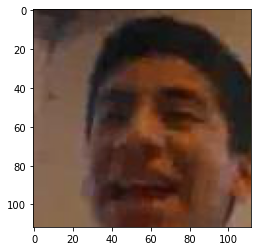

In [443]:
idx = 5000
img, l = train_dataset[idx]

plt.imshow(img.numpy().transpose(1, 2, 0)), l

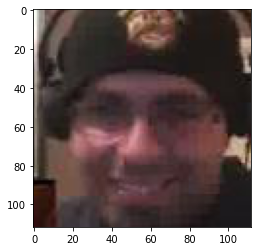

In [405]:
idx = 10
img, l = valid_dataset[idx]

plt.imshow(img.numpy().transpose(1, 2, 0))

In [375]:
class_count = {}
for i in tqdm(range(len(train_dataset.labels))):
    
    l = train_dataset.labels[i]
    
    if l not in class_count:
        class_count[l] = 0
    
    class_count[l] += 1
    

for k in class_count.keys():
    print(class_name[k], class_count[k])


Neutral 207309
Happiness 54918
surprise 7234
Anger 6144
Disgust 1872
Fear 841
Sadness 15752


In [376]:
class_count_v = {}
for i in tqdm(range(len(valid_dataset.labels))):
    
    l = train_dataset.labels[i]
    
    if l not in class_count_v:
        class_count_v[l] = 0
    
    class_count_v[l] += 1
    

for k in class_count_v.keys():
    print(class_name[k], class_count_v[k])


Neutral 44966
Happiness 12419
surprise 1545
Anger 1368
Disgust 687
Fear 409
Sadness 8198


# Testing Torch Dataset

In [312]:
dataset_train = AffWild2ExprDataset(remove_mismatch=True, compress=True, )
dataset_valid = AffWild2ExprDataset(train=False, remove_mismatch=True, compress=True)

In [313]:
len(dataset_train), len(dataset_valid)

(294070, 69592)

Test labels and video names matching

In [297]:
dataset_train.video_names == dataset_train.label_names, len(dataset_train)

(True, 111)

In [298]:
dataset_valid.video_names == dataset_valid.label_names, len(dataset_valid)

(True, 26)

Test labels and video length matching

In [314]:
for i in range(len(dataset_train.videos)):
    assert len(dataset_train.videos[i]) == len(dataset_train.labels[i])

TypeError: object of type 'numpy.int64' has no len()

Test __getitem__

In [309]:
vid, label = dataset_train[0]

In [310]:
vid.shape, label.shape

(torch.Size([2595, 112, 112, 3]), torch.Size([2595]))